In [1]:
# What is the prey overlap among the training and test sets?

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import cullin_benchmark_test as cb
from scipy.special import comb
from itertools import combinations
import matplotlib_venn as venn


In [2]:
dpath = '../../data/raw/cullin_e3_ligase/'
dpath = Path(dpath)

bench = cb.CullinBenchMark(dpath)
nbaits = len(bench.baits)
it = range(nbaits)

sels = {i: bench.data['Bait'] == bench.baits[i] for i in it}
prey = {i: bench.data.loc[sels[i], "Prey"] for i in it}
unique_prey = {i: set(prey[i]) for i in it}
n_unique_prey = {i: len(unique_prey[i]) for i in it}

training_saint_threshold = 0.3

criteria = bench.data['SaintScore'] >= training_saint_threshold

top_scoring_prey = {i: bench.data.loc[(sels[i] & criteria), "Prey"] for i in it}
unique_top_scoring_prey = {i: set(top_scoring_prey[i]) for i in it}

pairs = list(combinations(it, 2))
baits = list(combinations(bench.baits, 2))

In [3]:
def get_unique_prey(bait_name: str, saint_threshold: float, df: pd.DataFrame):
    sel1 = df['SaintScore'] >= saint_threshold
    sel2 = df["Bait"] == bait_name
    return set(df.loc[(sel1 & sel2), "Prey"])

def get_unique_prey_list(bait_names: list[str], saint_threshold: float, df: pd.DataFrame):
    prey_sets = []
    for bait_name in bait_names:
        prey_sets.append(get_unique_prey(bait_name, saint_threshold, df))
    return prey_sets

def plot_venn3_from_threshold(bench, 
                              saint_threshold,
                              set_labels = None,
                              title=None,
                              set_colors = None,
                              venn3_kwargs = None):
    if not title:
        title = f"SaintScore {saint_threshold}"
        
    if not set_labels:
        set_labels = [i.strip("wt_MG132") for i in bench.baits]
        
    if not set_colors:
        set_colors = ('r', 'g', 'b')
        
    if not venn3_kwargs:
        venn3_kwargs = {}
    prey_sets = get_unique_prey_list(bench.baits, saint_threshold, bench.data)
    plt.title(title)
    venn.venn3(prey_sets, set_labels=set_labels, set_colors=set_colors, **venn3_kwargs)

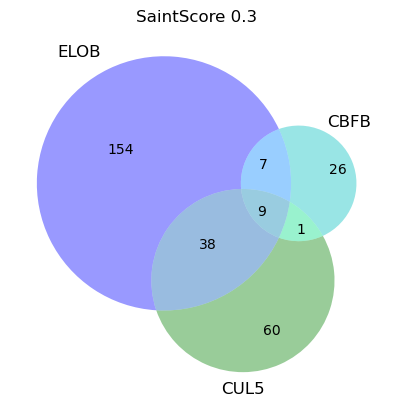

In [4]:
plot_venn3_from_threshold(bench, 0.3, set_colors=('b', 'c', 'g'), venn3_kwargs={'alpha': 0.4})

In [5]:
?venn.venn3

In [6]:
unique_ven = {}
top_scoring_ven = {}
for i in it:
    j, k = pairs[i]
    bait1 = bench.baits[j]
    bait2 = bench.baits[k]
    assert j != k
    
    intersection = len(unique_prey[j].intersection(unique_prey[k]))
    top_scoring_intersection = len(unique_top_scoring_prey[j].intersection(unique_top_scoring_prey[k]))
    
    name = bait1 + "-" + bait2
    unique_ven[name] = intersection
    top_scoring_ven[name] = top_scoring_intersection
    
name = ""
for i in it:
    name += bench.baits[i]
    name += "-"
name = name.strip("-")

inter1 = unique_prey[0].intersection(unique_prey[1])
inter1 = inter1.intersection(unique_prey[2])

top1 = unique_top_scoring_prey[0].intersection(unique_top_scoring_prey[1])
top1 = top1.intersection(unique_top_scoring_prey[2])

unique_ven[name] = len(inter1)
top_scoring_ven[name] = len(top1)

del top1
del inter1

for i in it:
    unique_ven[bench.baits[i]] = len(unique_prey[i])
    top_scoring_ven[bench.baits[i]] = len(unique_top_scoring_prey[i])
    
    
    

    

In [7]:
unique_ven

{'ELOBwt_MG132-CBFBwt_MG132': 1641,
 'ELOBwt_MG132-CUL5wt_MG132': 1796,
 'CBFBwt_MG132-CUL5wt_MG132': 1836,
 'ELOBwt_MG132-CBFBwt_MG132-CUL5wt_MG132': 1573,
 'ELOBwt_MG132': 2158,
 'CBFBwt_MG132': 2094,
 'CUL5wt_MG132': 2303}

In [8]:
top_scoring_ven

{'ELOBwt_MG132-CBFBwt_MG132': 16,
 'ELOBwt_MG132-CUL5wt_MG132': 47,
 'CBFBwt_MG132-CUL5wt_MG132': 10,
 'ELOBwt_MG132-CBFBwt_MG132-CUL5wt_MG132': 9,
 'ELOBwt_MG132': 208,
 'CBFBwt_MG132': 43,
 'CUL5wt_MG132': 108}

In [9]:
len(list(unique_prey.values()))

3

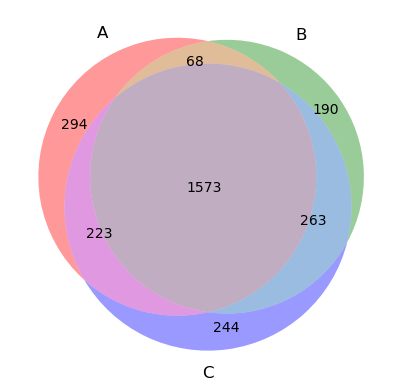

In [10]:
venn.venn3(list(unique_prey.values()))


Text(0.5, 1.0, 'Training Test Prey Overlap')

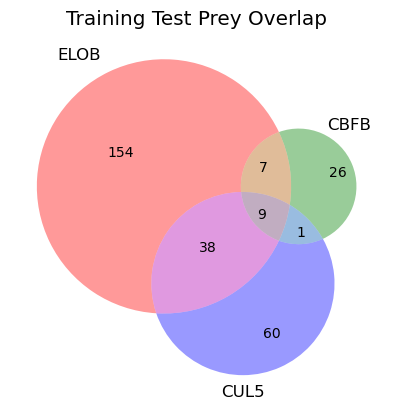

In [11]:
fig, ax = plt.subplots()
plt.style.use('ggplot')
venn.venn3(list(unique_top_scoring_prey.values()),
          set_labels=[i.strip('wt_MG132') for i in bench.baits],
          ax=ax)

plt.title("Training Test Prey Overlap")

In [23]:
bench.baits[2]
ncul5 = len(top_scoring_prey[2])
ncbfb = len(top_scoring_prey[1])
nelob = len(top_scoring_prey[0])

elob_shared_edges = comb(16, 2)
cul5_shared_edges = comb(10, 2)
elob_total_edges = comb(nelob, 2)
cul5_total_edges = comb(ncul5, 2)

elob_percent = (elob_shared_edges / elob_total_edges) * 100
cul5_percent = (cul5_shared_edges / cul5_total_edges) * 100
elob_percent, cul5_percent

report = f"""elob:
  n-prey {nelob}
  n-edges {elob_total_edges}
  n-shared {elob_shared_edges}
  percent  {elob_percent}
cul5:
  n-prey {ncul5}
  n-edges {cul5_total_edges}
  n-shared {cul5_shared_edges}
  percent  {cul5_percent}
cbfb:
  n-prey {ncbfb}
"""
print(report)

elob:
  n-prey 208
  n-edges 21528.0
  n-shared 120.0
  percent  0.5574136008918618
cul5:
  n-prey 108
  n-edges 5778.0
  n-shared 45.0
  percent  0.778816199376947
cbfb:
  n-prey 43



['ELOBwt_MG132', 'CBFBwt_MG132', 'CUL5wt_MG132']

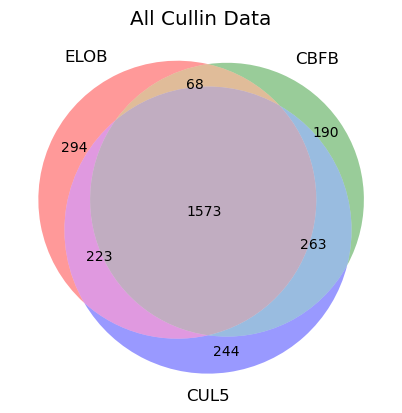

In [13]:
fig, ax = plt.subplots()
plt.title("All Cullin Data")
plt.style.use('ggplot')
venn.venn3(list(unique_prey.values()),
          set_labels=[i.strip('wt_MG132') for i in bench.baits],
          ax=ax)
plt.show()

In [26]:
bench.parse_spec_counts()

In [83]:
it2 = range(1, 5)
replicates = [f"r{i}" for i in it2]
columns = ["Prey"] + replicates

b = [bench.data.loc[(sels[i] & criteria), columns] for i in it]
for bx in b:
    bx['mu'] = np.mean(bx.loc[:, replicates].values, axis=1)
    bx['std'] = np.std(bx.loc[:, replicates].values, axis=1)
    
i0 = set(b[0].loc[:, "Prey"]).intersection(b[1].loc[:, "Prey"])
i1 = set(b[1].loc[:, "Prey"]).intersection(b[2].loc[:, "Prey"])
i2 = set(b[0].loc[:, "Prey"]).intersection(b[2].loc[:, "Prey"])


corr_sel_i0 = [prey in i0 for prey in bench.data['Prey']]
corr_sel_i1 = [prey in i1 for prey in bench.data['Prey']]
corr_sel_i2 = [prey in i2 for prey in bench.data['Prey']]

criteria2 = [bait in ("CBFBwt_MG132", "ELOBwt_MG132") for bait in bench.data['Bait']]
columns2 = ["Bait"] + columns
inter_corr_elob = bench.data.loc[(corr_sel_i0 & criteria & criteria2), columns2]
inter_corr_elob['mu'] = np.mean(inter_corr_elob.loc[:, replicates].values, axis=1)

x = []
y = []

for prey in i0:
    s1 = inter_corr_elob["Prey"] == prey
    s2 = inter_corr_elob["Bait"] == "CBFBwt_MG132"
    x.append(np.mean(inter_corr_elob.loc[s1 & s2, replicates]))
    


len(i0), len(i1), len(i2)

/home/aji/anaconda3/envs/pynet/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/aji/anaconda3/envs/pynet/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/aji/anaconda3/envs/pynet/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype,

(16, 10, 47)

,Bait,Prey,r1,r2,r3,r4,mu
0,CBFBwt_MG132,vifprotein,22,22,26,34,26.00
1,CBFBwt_MG132,Q9UBF6,9,11,12,16,12.00
3,CBFBwt_MG132,Q93034,78,77,66,99,80.00
4,CBFBwt_MG132,Q8TEB1,24,19,15,11,17.25
5,CBFBwt_MG132,Q15370,23,23,24,33,25.75
6,CBFBwt_MG132,Q15369,17,19,18,21,18.75
7,CBFBwt_MG132,Q13951,42,46,29,48,41.25
10,CBFBwt_MG132,Q13617,70,75,77,85,76.75
12,CBFBwt_MG132,Q8WUM4,5,8,3,2,4.50
13,CBFBwt_MG132,Q9C0C7,1,6,7,9,5.75


,Prey,r1,r2,r3,r4,mu,std
4397,vifprotein,29,30,16,18,23.25,6.299802
4398,Q9Y6I7,21,23,10,12,16.50,5.590170
4399,Q9Y675,4,3,5,5,4.25,0.829156
4400,Q9Y576,44,42,31,32,37.25,5.804093
4401,Q9Y575,36,43,27,42,37.00,6.363961
...,...,...,...,...,...,...,...
4600,O75600,2,1,4,2,2.25,1.089725
4601,Q9Y6K9,3,0,1,3,1.75,1.299038
4602,Q96R06,2,1,3,4,2.50,1.118034
4603,Q5H9R7,2,2,7,5,4.00,2.121320


{'O00165',
 'P19838',
 'Q13617',
 'Q13951',
 'Q15369',
 'Q15370',
 'Q15843',
 'Q8N1F7',
 'Q8TEB1',
 'Q8WUM4',
 'Q93034',
 'Q9C0C7',
 'Q9UBF6',
 'Q9ULX6',
 'Q9Y4X5',
 'vifprotein'}

In [60]:
bench.baits[1]

'CBFBwt_MG132'